<a href="https://colab.research.google.com/github/aadyakoirala/analytics-projects/blob/main/RD_DID_ErasTour_HotelSpending_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RD DID ErasTour_HotelSpending





### PART 1: DID
In this week's lab, we worked with hotel spending data to assess the impact of the Eras tour on the hotel industry.



For this assignment, you will produce your own version of a difference-in-difference analysis of the Eras tour impact, using the same data we used in class.





In [ ]:
# 1. preliminaries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# load the data
url = 'https://raw.githubusercontent.com/dansacks/gb740/refs/heads/main/hotel_spend.csv'
data = pd.read_csv(url)



## Question 1
Design a difference-in-differences analysis. Specifically, select from the list of metro areas (see canvas or [here](https://raw.githubusercontent.com/dansacks/gb740/refs/heads/main/top50_metros_dates.csv)) a metro area for your "treated" area and a metro area for your "control" area that you think would be appropriate for the analysis. Do not pick Pittsburgh or St. Louis. Explain why you chose them, taking care to explain at a conceptual level why you expect your control area to be appropriate. Explain what is the "pre" period and what is the "post" period.



### 1.a
#### What are yout treated and control metros?

You should pick a treated city and an untreated, with appropriate justification given below.

Treated: Seattle-Tacoma

Control: Portland, Oregon


### 1.b   
#### Explain why you chose them, taking care to explain at a conceptual level why you expect your control area to be appropriate



Your explanation should explain why parallel trends might be satisfied. Similar seasonality in tourism or economic forces is a key consideration.

Seattle hosted Taylor Swift’s Eras Tour concerts on the week of July 18, 2023, while Portland did not have shows in that time frame. They are both large West Coast metro areas, although Seattle (4 million) is lager than Portland (2.5 million).  They are both in the Pacific northwest and therefore have similar weather and possibly similar seasonality in tourism.


### 1.c.
#### Explain what is the "pre" period and the "post" or "treated" period.




The pre-period is defined as the week before the Eras Tour in the treated city, and the post-period as the week including and following the concert dates. For Seattle, which hosted the Eras Tour on July 18, 2023, the pre-period corresponds to the week before this date, and the post-period corresponds to the week of July 18. These are weeks 28 and 29.

## Question 2

Find the mean of the outcome metric in your treated and control areas, in the pre period and in the concert period. What is the simple DID estimate?


In [ ]:
treat_code = 42660
control_code = 38900
treat_post = data.loc[ (data['cbsa_code']==treat_code) & (data['week_num']==29),
                      'total_spend'].item()
treat_pre = data.loc[ (data['cbsa_code']==treat_code) & (data['week_num']==28),
                      'total_spend'].item()
control_post = data.loc[ (data['cbsa_code']==control_code) & (data['week_num']==29),
                      'total_spend'].item()
control_pre = data.loc[ (data['cbsa_code']==control_code) & (data['week_num']==28),
                      'total_spend'].item()

print('Treat-post outcome', treat_post)
print('Treat-pre outcome', treat_pre)
print('Control-post outcome', control_post)
print('Control-pre outcome', control_pre)

# B. Calculate DID estimate
did = (treat_post - treat_pre) - (control_post - control_pre)
print('DID estimate: ', did)



Treat-post outcome 355797.85
Treat-pre outcome 284141.96
Control-post outcome 108583.09
Control-pre outcome 90185.981
DID estimate:  53258.78099999996


### Explain in words what this estimate means

The DID estimate is $53,259. The Eras tour increased hotel spending in Seattle by 53 thousand dollars.

## Question 3

Estimate the DID model by regression.

In [ ]:
data['post'] = (data['week_num']==29).astype(int)
data['treat'] = (data['cbsa_code']==treat_code).astype(int)
data['post_treat'] =data['post']*data['treat']


# Subset to treated + control metros
est_data = data.loc[(data['cbsa_code']==treat_code) | (data['cbsa_code']==control_code)]

did_formula = 'total_spend ~ post + treat + post:treat'
did_model = smf.ols(formula = did_formula, data = est_data).fit()

print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_spend   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     127.5
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           4.79e-34
Time:                        20:20:41   Log-Likelihood:                -1258.2
No. Observations:                 104   AIC:                             2524.
Df Residuals:                     100   BIC:                             2535.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.565e+04   6203.174     12.195      0.0

## Question 4
4.a: What assumptions does your DID model require?

We require the parallel trends assumption, that in the absence of treatment, Seattle and Portland's hotel spending would have evolved in paralle.

4.b: Provide evidence to assess that assumption,

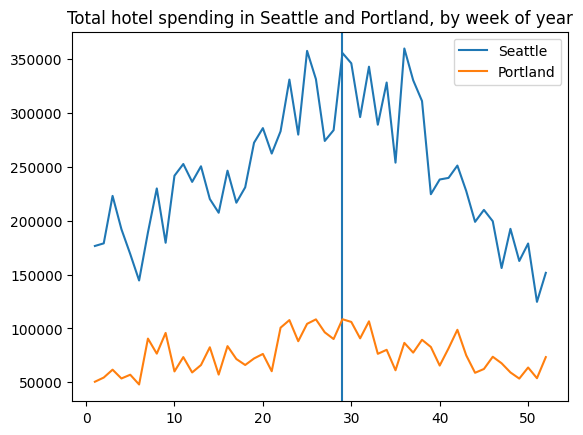

In [ ]:

T_data = data[ data['cbsa_code']==treat_code]
C_data = data[ data['cbsa_code']==control_code]

# A. Start with Seattle
plt.plot(T_data['week_num'], T_data['total_spend'], label='Seattle')
plt.axvline(29)

# add  sandiego and a legend
plt.plot(C_data['week_num'], C_data['total_spend'], label = 'Portland')
plt.title("Total hotel spending in Seattle and Portland, by week of year")
plt.legend()

## Question 5

What conclusions can you draw, if any, from this analysis?



A good answer here notes whether parallel trends seems satisfied and if so concludes with the effect of the Eras Tour for the treated city. Otherwise it does not draw conclusions.

I see some violation of paralell trends here. Spending is increasing in Seattle in the weeks leading up the concert. Therefore I hesitate to draw any conclusions.


## PART 2: RD

You will use regression discontinuity to estimate the effect of default suggestion (dollar vs. percent) on the tipping rate, defined as the % of the fare left as a tip.  

To speed up computation, you may want to aggregate to the mean of the variables, by fare.


In [ ]:
# run only once per session
!pip install rdrobust
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from rdrobust import rdrobust, rdplot

In [ ]:

# preliminaries
url = 'https://raw.githubusercontent.com/dansacks/gb740/main/tips.csv'
data = pd.read_csv(url)

# you may want to aggregate the data to the means by fare
data.columns

data['tip_pct'] = data['tip'] / data['fare']
agg_data = data.groupby('fare').agg({
    'tip_pct' : 'mean',
    'ride_duration' : 'mean',
    'distance' : 'mean' ,
    'passenger_count':'mean'
}).reset_index()

data.head()


,fare,tip,ride_duration,distance,passenger_count,day,tip_pct
0,2.9,0.25,2,0.25,1,2,0.086207
1,2.9,1.00,2,0.28,5,6,0.344828
2,2.9,1.00,2,0.28,1,3,0.344828
3,2.9,0.50,1,0.29,1,6,0.172414
4,2.9,0.50,2,0.16,1,5,0.172414


### Question 6:
Find  is the RDD estimate of the effect of the % default on tip amount?

In [ ]:
# code for q6
from rdrobust import rdplot, rdrobust
agg_data['score'] = agg_data['fare']-15
print( rdrobust(y=agg_data['tip_pct'], x=agg_data['score']) )




Call: rdrobust
Number of Observations:                    93
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            31         62
Number of Unique Obs.             31         62
Number of Effective Obs.           8          7
Bandwidth Estimation            2.99       2.99
Bandwidth Bias                  4.71       4.71
rho (h/b)                      0.635      0.635

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.016    0.002    8.726   2.632e-18      [0.013, 0.02]
Robust                 -        -    7.268   3.661e-13     [0.012, 0.021]



### Question 7:
What assumption(s) does your estimate require for validity? Give an example of how those assumptions could go wrong.

We require that (1) people cannot precisely manipulate the score, (2) the score is determined before the outcome, and (3) nothing else changes at the discontinuity.

1) can fail if drivers try to get the ride to last a bit longer so that they end up over the threshold.

2) can fail if tips are determined before fares, but they are not.

3) can fail if other things about the payment experience or ride changes when the fare exceeds $15. This seems very unlikely.


### Question 8
Provide and discuss  (a) that there really is an effect of tip default on topping, and (b) that your RDD is valid? Your answer here should be a few plots, along with discussion of what the plots show and why they are informative.


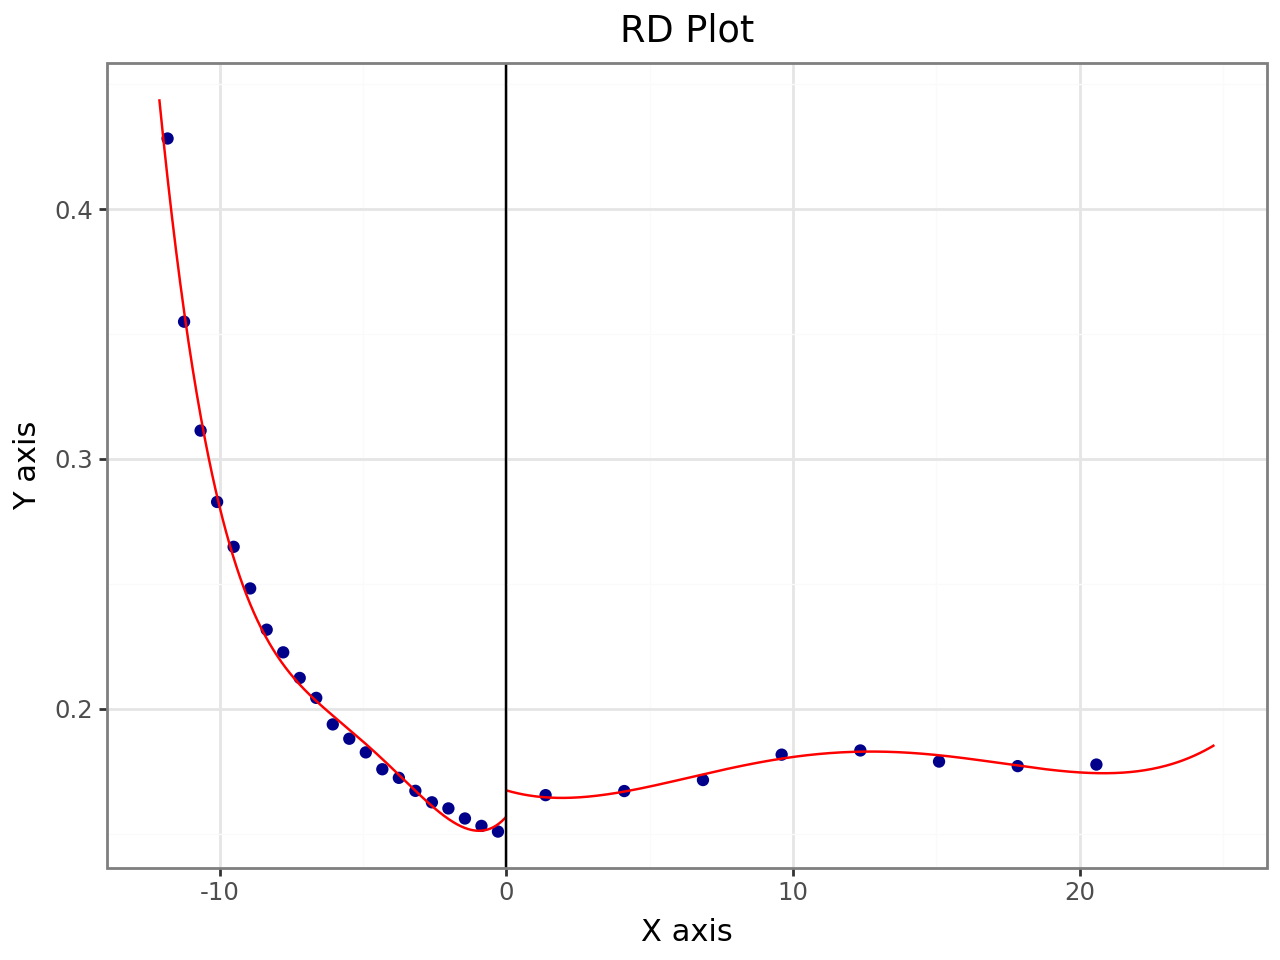

Call: rdplot
Number of Observations:                    93
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations            31         62
Number of Effective Obs           31         62
Bandwith poly. fit (h)          12.1       24.7
Number of bins scale               1          1
Bins Selected                     21          9
Average Bin Length             0.576      2.744
Median Bin Length              0.576      2.744
IMSE-optimal bins               21.0        9.0
Mimicking Variance bins        187.0        8.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [ ]:
# code for question 8 - part 1: rd plot
rdplot(y=agg_data['tip_pct'], x=agg_data['score'], c=0, binselect='es')




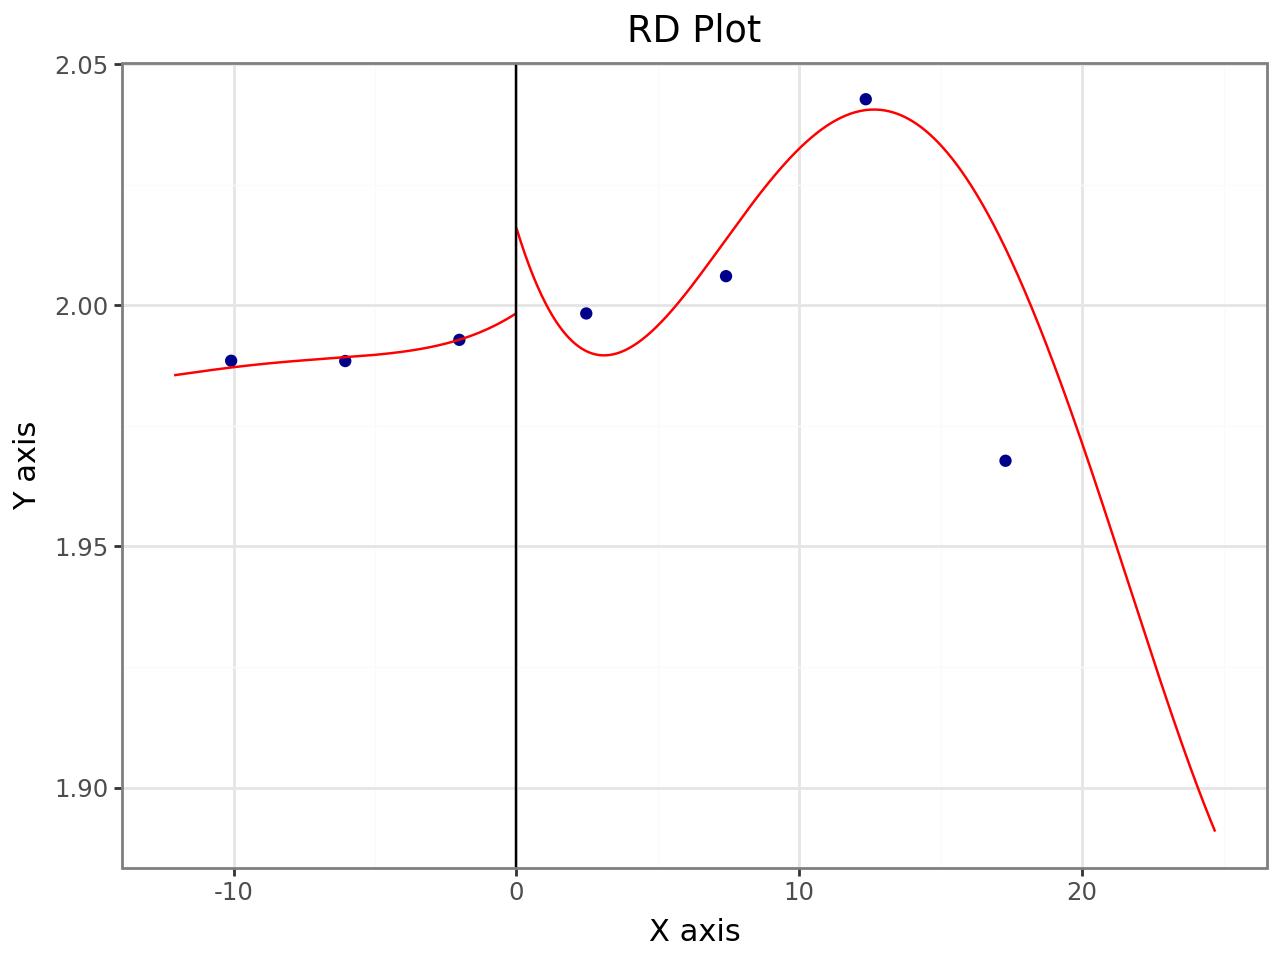

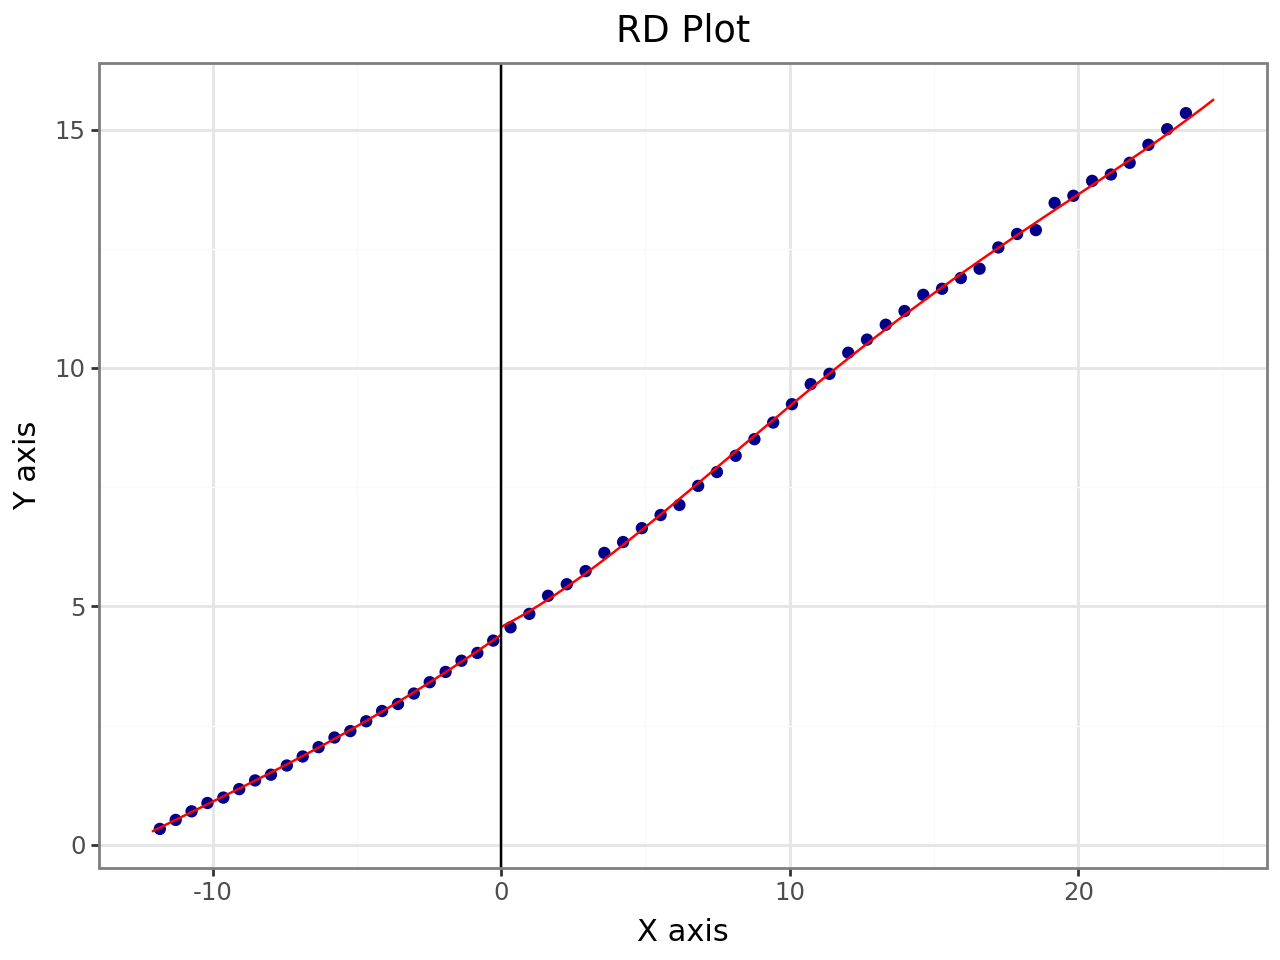

Call: rdplot
Number of Observations:                    93
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations            31         62
Number of Effective Obs           31         62
Bandwith poly. fit (h)          12.1       24.7
Number of bins scale               1          1
Bins Selected                     22         38
Average Bin Length              0.55       0.65
Median Bin Length               0.55       0.65
IMSE-optimal bins               22.0       38.0
Mimicking Variance bins        698.0     1980.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [ ]:
# show no discontinuity in covariates
rdplot(y=agg_data['passenger_count'], x=agg_data['score'], c=0, binselect='es')


rdplot(y=agg_data['distance'], x=agg_data['score'], c=0, binselect='es')

There is a clear discontinuity in tip percent at the threshold, evidence of an effect. There is also no evidence of discontinuities in the pre-treatment variables - paassenger count and distance are smooth. This is evidence that there is not manipulation of the score.